## Test Single Cell

In [1]:
from Ionic_current.Ord11 import Ord11_model
from PermanentConstants import Constants
import torch
import math
import time

device = torch.device('cpu')
dtype = torch.float32

In [35]:
const = Constants(
            device=device,
            dtype=dtype,
            Ncell=1,
            nbeats=1,
            dt_factor=1,
            stim_amplitude=20
            )
parameters = const.parameters

In [ ]:
ti = 0.0
phi_i = const.phi0.clone()
G_i   = const.g0.clone()
S     = const.S.clone()
state = torch.cat((phi_i, G_i), dim=0)
N = parameters['N']
phi_save  = []
start = time.time()

while ti < const.T:

    if abs(math.fmod(ti, const.parameters['bcl'])) < const.twin:
        dt = const.dt1; dt_samp = const.dt1_samp; Ns = const.Ns1
    else:
        dt = const.dt2; dt_samp = const.dt2_samp; Ns = const.Ns2

   
    if abs(math.fmod(ti, 500)) < 1e-9:
        print(f'time: {ti:.2f} ms')
    parameters['dt'] = dt

    Iion, _, G_new, dX =  Ord11_model(ti, state, parameters, S, device, dtype)

    phi_new = state[0:N] + dt*(-Iion/parameters['Ctot'])
    state[0:N] = phi_new
    state[N:]  = G_new
    if abs(math.fmod(ti, dt_samp)) < 1e-8:
        phi_save.append(phi_new.clone())
    if any(torch.isnan(phi_new)):
        print('NaN detected in membrane potential!')
        break
    ti = round(ti + dt, 5) 
    # ti += dt
end = time.time()
phi_save = torch.stack(phi_save, dim=0)
print(f'Simulation time: {end - start:.2f} seconds')

time: 0.00 ms


Text(0, 0.5, 'Membrane Potential (mV)')

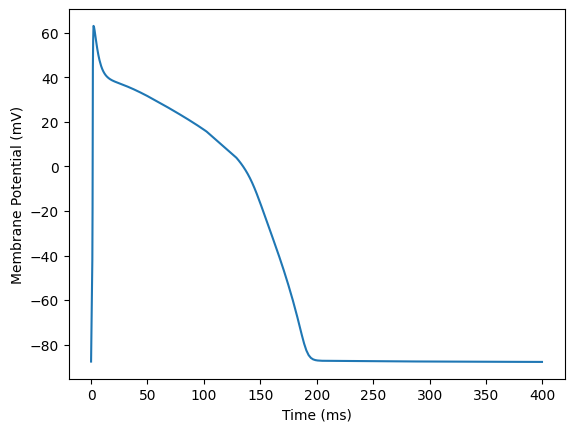

In [ ]:
import matplotlib.pyplot as plt
phi_plot = phi_save[:, 0].cpu().numpy()
ts       = const.ts
plt.plot(ts, phi_plot)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')

## Continuous Cable Equation

The 1D cable equation with ionic current is:

$$
C_m \frac{\partial V}{\partial t}
= D \frac{\partial^2 V}{\partial x^2}
- I_{\text{ion}}(t, x)
$$

### Spatial Discretization

Using a second-order central difference for the Laplacian:

$$
\frac{\partial^2 V}{\partial x^2} \Big|_i
\approx
\frac{V_{i+1}^n - 2V_i^n + V_{i-1}^n}{(\Delta x)^2}
$$

### Explicit Euler Update

$$
V_i^{n+1}
=
V_i^{n}
+
\Delta t
\left[
\frac{D}{C_m (\Delta x)^2}
\left(
V_{i+1}^n - 2V_i^n + V_{i-1}^n
\right)
-
\frac{I_{\text{ion}, i}^n}{C_m}
\right]
$$

### Matrix form

$$\mathbf{V}^n = [v_1^n,v_2^n,\cdots , v_{N-1}^n,v_N^n]^T$$

Consider Neumann B.C.
$$
\mathbf{L}_g = 
\begin{bmatrix}
-1 & 1 & 0 & \dots & 0 \\
1 & -2 & 1 & \dots & 0 \\
0 & 1 & -2 & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & 1 \\
0 & 0 & 0 & 1 & -1
\end{bmatrix}
$$

Update term,

$$
\mathbf{V}^{n+1} = \underbrace{\left( \mathbf{I} + \Delta t \frac{D}{C_m (\Delta x)^2} \mathbf{L}_g \right) }_{M}\mathbf{V}^n - \Delta t \frac{1}{C_m} \mathbf{I}_{\text{ion}}^n
$$

In [ ]:
from Ionic_current.Ord11 import Ord11_model
from PermanentConstants import Constants
import torch
import math
import time

def create_diffusion_mat(N: int, dtype=torch.float32, device=None) -> torch.Tensor:
    if N < 1:
        raise ValueError("N must be at least 1.")

    diag_val = torch.full((N,), -2.0, dtype=dtype, device=device)
    diag_val[0] = -1.0
    diag_val[-1] = -1.0
    
    off_diag_val = torch.full((2 * (N - 1),), 1.0, dtype=dtype, device=device)
    
    indices_i = torch.cat([
        torch.arange(N, device=device),
        torch.arange(N - 1, device=device),
        torch.arange(N - 1, device=device) + 1
    ])
    
    indices_j = torch.cat([
        torch.arange(N, device=device),
        torch.arange(N - 1, device=device) + 1,
        torch.arange(N - 1, device=device)
    ])
    
    indices = torch.stack([indices_i, indices_j])
    values = torch.cat([diag_val, off_diag_val])
    
    return torch.sparse_coo_tensor(indices, values, (N, N), dtype=dtype, device=device)

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
dtype = torch.float32

const = Constants(
            device=device,
            dtype=dtype,
            Ncell=100,
            nbeats=2,
            dt_factor=1,
            stim_amplitude=20
            )
parameters = const.parameters

D = 1    # Diffusion coefficient (100 μm^2/ms = 1e-3 cm^2/ms)
dx  = 125  # Grid spacing in μm (0.0125 cm)      
Ctot = parameters['Ctot']
Ncell = parameters['Ncell']
ti = 0.0
count = 0
dt = 0.01
phi_i = const.phi0.clone()
G_i   = const.g0.clone()
S     = const.S.clone()
state = torch.cat((phi_i, G_i), dim=0)
N = parameters['N']
phi_save  = []
start = time.time()
T = []

Lg = create_diffusion_mat(Ncell, dtype=dtype, device=device)
M = dt * D / (Ctot * dx**2) * Lg + torch.eye(Ncell, dtype=dtype, device=device).to_sparse()
while ti < const.T:

    # if abs(math.fmod(ti, const.parameters['bcl'])) < const.twin:
    #     dt = const.dt1; dt_samp = const.dt1_samp; Ns = const.Ns1
    # else:
    #     dt = const.dt2; dt_samp = const.dt2_samp; Ns = const.Ns2
    if dt * D / (Ctot * dx**2) > 0.5:
        raise ValueError("Stability condition violated: dt * D / (Ctot * dx^2) must be <= 0.5", dt * D / (Ctot * dx**2))
   
    if abs(math.fmod(ti, 10)) < 1e-8:
        print(f'time: {ti:.2f} ms')
    parameters['dt'] = dt

    Iion, _, G_new, dX =  Ord11_model(ti, state, parameters, S, device, dtype)

    phi_new = M @ state[0:N] + dt*(-Iion/parameters['Ctot'])
    state[0:N] = phi_new
    state[N:]  = G_new
    # phi_i = phi_new.clone()
    if abs(math.fmod(count, 10)) < 1e-8:
        phi_save.append(phi_new.clone())
        T.append(ti)
    
    if count % 1000 == 0:
        if any(torch.isnan(phi_new)):
            print('NaN detected in membrane potential!, time:', ti)
            break
    # ti = round(ti + dt, 5) 
    ti += dt
    count += 1
end = time.time()
phi_save = torch.stack(phi_save, dim=0)

print(f'Simulation time: {end - start:.2f} seconds')

time: 0.00 ms
time: 20.00 ms
time: 30.00 ms
time: 40.00 ms
time: 80.00 ms
time: 90.00 ms
time: 100.00 ms
time: 110.00 ms
time: 120.00 ms
time: 130.00 ms
time: 140.00 ms
time: 150.00 ms
Simulation time: 157.09 seconds


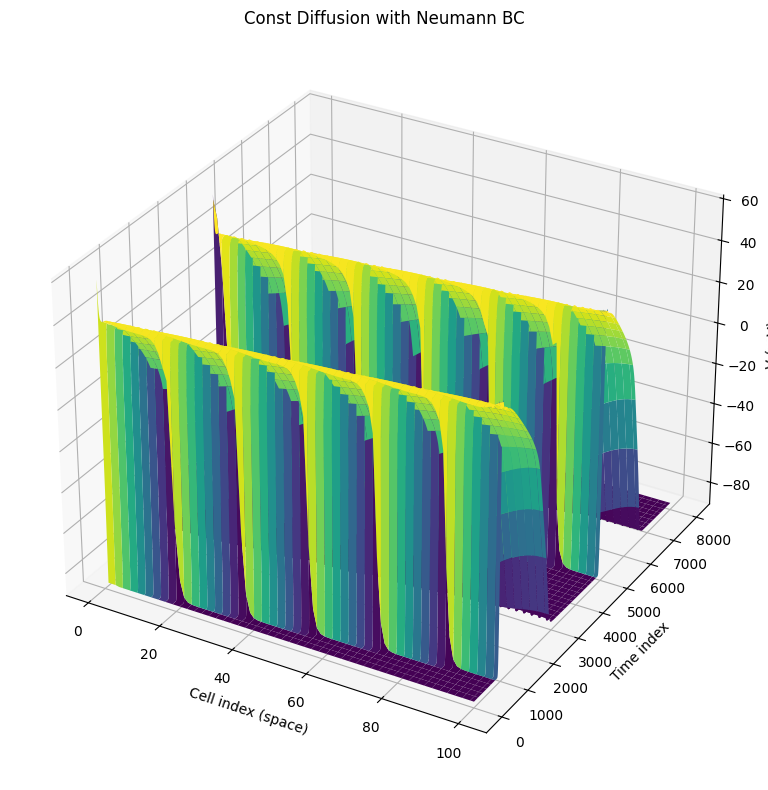

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data_u = phi_save 

m, n = data_u.shape

X, Y = np.meshgrid(np.arange(1, n+1), np.arange(1, m+1))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, data_u, cmap='viridis', edgecolor='none')

ax.set_xlabel('Cell index (space)')
ax.set_ylabel('Time index')
ax.set_zlabel('V (mV)')
ax.set_title('Const Diffusion with Neumann BC')

plt.tight_layout()
plt.show()


### Test B.C.

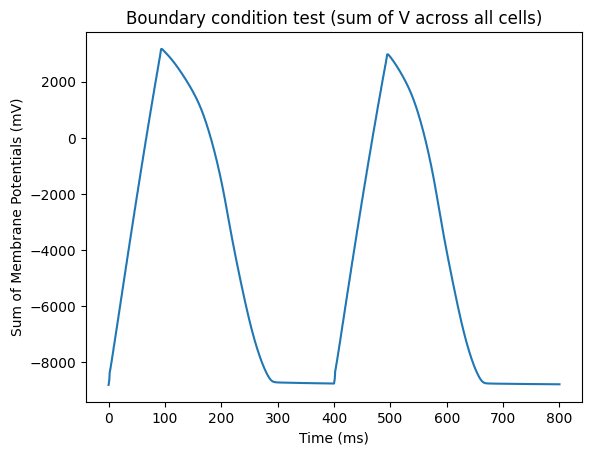

In [ ]:
test = data_u.T.sum(axis=0)
t = np.array(T)
plt.plot(t, test)
plt.xlabel('Time (ms)')
plt.ylabel('Sum of Membrane Potentials (mV)')
plt.title('Boundary condition test (sum of V across all cells)')
plt.show()

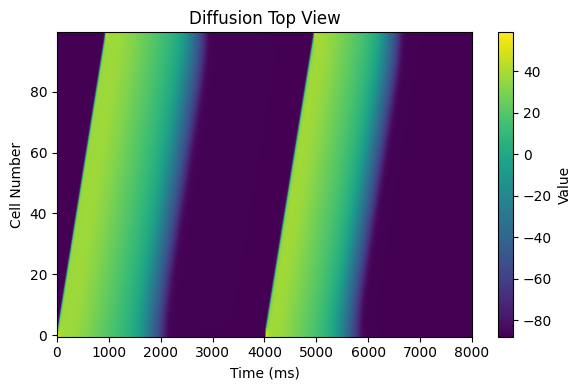

In [ ]:
plt.figure(figsize=(6,4))
plt.imshow(data_u.T, 
           aspect='auto', 
           origin='lower',  
           cmap='viridis') 

plt.colorbar(label='Value')
plt.xlabel('Time (ms)')
plt.ylabel('Cell Number')
plt.title('Diffusion Top View')
plt.tight_layout()
plt.show()

### Test ID NN connection

We test with FEM_data1.m with parameters: $d = 5\mu m\,\, d_{ip} = 10 nm\,\, d_{p} = 10nm\,\,A_{f} = 0nm\,\,h_{ip} = 3.2\mu m$

In [3]:
from Ionic_current.Ord11 import Ord11_model
from PermanentConstants import Constants,Normalization
import torch
import math
import time
from model import MLP
import joblib


device = torch.device('cpu')
dtype = torch.float32
GJ_coupling = 'strong'
full_seq = True

if full_seq:
    best_model_state_name = f"Model_state/MLP/best_mlp_{GJ_coupling}_fullseq.pth"
else:
    best_model_state_name = f"Model_state/MLP/best_mlp_{GJ_coupling}_fullseq.pth"

if GJ_coupling.lower() == 'strong':
    GJ = 735  # nS
    scaler_name = 'Scaler/strong_standard_scaler.pkl'
else:
    GJ = 73.5 # nS
    scaler_name = 'Scaler/weak_standard_scaler.pkl'

# Load the scaler
scaler = joblib.load(scaler_name)

normalize = Normalization(scaler, device=device, dtype=dtype)
mesh_parameters = torch.tensor(
    [100.0, 0.1, 0.1, 0.0, 32, 735.0],
    device=device,
    dtype=dtype
)  # d, dip, dp, Af, hip, Ggap
hidden_dims = [128, 128, 256, 256, 128]
const = Constants(
            device=device,
            dtype=dtype,
            Ncell=10,
            nbeats=1,
            dt_factor=1,
            stim_amplitude=50
            )
parameters = const.parameters
mesh_parameters = mesh_parameters.unsqueeze(0).repeat(parameters['N'], 1)  # (N, 6)
input_features = 9
output_features = 2
model = MLP(input_features, hidden_dims, output_features,dropout=0.1)
model.load_state_dict(torch.load(best_model_state_name))
model.to(device)
model.eval()

MLP(
  (mlp): Sequential(
    (0): ResidualBlock(
      (net): Sequential(
        (0): Linear(in_features=9, out_features=128, bias=True)
        (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (2): SiLU()
        (3): Dropout(p=0.1, inplace=False)
      )
      (proj): Linear(in_features=9, out_features=128, bias=True)
    )
    (1): ResidualBlock(
      (net): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (2): SiLU()
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (2): ResidualBlock(
      (net): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (2): SiLU()
        (3): Dropout(p=0.1, inplace=False)
      )
      (proj): Linear(in_features=128, out_features=256, bias=True)
    )
    (3): ResidualBlock(
      (net): Sequential(
        (0): Linea

## Main simulation forward Euler

In [6]:
ti = 0.0
phi_i     = const.phi0.clone()
G_i       = const.g0.clone()
S         = const.S.clone()
state     = torch.cat((phi_i, G_i), dim=0)
N         = parameters['N']
phi_save  = []
start     = time.time()
Ctot      =parameters['Ctot']
a         = 1
with torch.no_grad():
    while ti < const.T:

        if abs(math.fmod(ti, const.parameters['bcl'])) < const.twin:
            dt = const.dt1; dt_samp = const.dt1_samp; Ns = const.Ns1
        else:
            dt = const.dt2; dt_samp = const.dt2_samp; Ns = const.Ns2

    
        if abs(math.fmod(ti, 100)) < 1e-5:
            print(f'time: {ti:.2f} ms')
        parameters['dt'] = dt

        #phi_i = torch.clamp(phi_i, min=-120.0, max=60.0)
        
        phi_pad  = torch.cat([phi_i[:1], phi_i, phi_i[-1:]], dim=0) # (N+2,)
        Vf = phi_pad.unfold(dimension=0, size=3, step=1)     # (N, 3)
        out = torch.cat([Vf, mesh_parameters], dim=1)  # (N, 9)
        normalize_out = normalize.normalizeV(out)
        I_cleft = model(normalize_out)  # (N, 2)
        # I_cleft = normalize.denormalizeI(I_cleft)
        I_cleft[0,0] = 0.0  # Fix for boundary cell
        I_cleft[-1,-1] = 0.0 # Fix for boundary cell
        I_cleft = I_cleft[:,0] + I_cleft[:,1]  # (N,)
        I_cleft = a * I_cleft

        Iion, _, G_new, _ =  Ord11_model(ti, state, parameters, S, device, dtype)
        if torch.isnan(Iion).any():
            print('NaN already in Iion! time:', ti)
            break

        phi_i = state[0:N] -dt/Ctot*(Iion + I_cleft)
        state[0:N] = phi_i
        state[N:]  = G_new
        if abs(math.fmod(ti, dt_samp)) < 1e-8:
            phi_save.append(phi_i.clone())
        if any(torch.isnan(phi_i)):
            print('NaN detected in membrane potential!')
            breakpoint()
            break
        ti = round(ti + dt, 5) 
        # ti += dt
    end = time.time()
    phi_save = torch.stack(phi_save, dim=0)
    print(f'Simulation time: {end - start:.2f} seconds')

time: 0.00 ms
NaN already in Iion! time: 0.13
Simulation time: 0.03 seconds


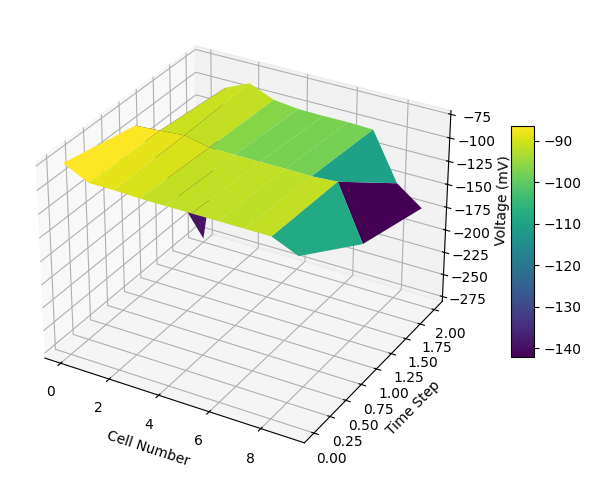

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# phi_save: shape (T_steps, N_cells)
data = phi_save.cpu().numpy()

T_steps, N_cells = data.shape

X = np.arange(T_steps)[:, None]           # time step axis
Y = np.arange(N_cells)[None, :]           # cell axis

X_grid, Y_grid = np.meshgrid(np.arange(N_cells),
                             np.arange(T_steps))

Z = data   # voltage


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X_grid, Y_grid, Z,
                       cmap='viridis', linewidth=0, antialiased=True)

ax.set_xlabel("Cell Number")
ax.set_ylabel("Time Step")
ax.set_zlabel("Voltage (mV)")

fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


### Single celft model

In [5]:
from Ionic_current.Ord11 import Ord11_model
from PermanentConstants import Constants
import torch
import os
import math
import time

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
dtype = torch.float32

const = Constants(
            device=device,
            dtype=dtype,
            Ncell=50,
            bcl=1000,
            nbeats=10,
            dt_factor=1,
            stim_amplitude=50,
            GJ_coupling=7.35e-5/4
            )
parameters = const.parameters

Ggap = parameters['Ggap']  # nS     
D = 0.1 # mm^2/msec
dx = 0.1 #mm    
Ctot = parameters['Ctot']
Ggap = Ctot * D / dx**2
Ncell = parameters['Ncell']
ti = 0.0
count = 0
dt = 0.01
phi_i = const.phi0.clone()
G_i   = const.g0.clone()
S     = const.S.clone()
state = torch.cat((phi_i, G_i), dim=0)
N = parameters['N']
phi_save  = []
I_gap_save = []
start = time.time()
T = []

while ti < const.T:
   
    if abs(math.fmod(ti, 1000)) < 1e-5:
        print(f'time: {ti:.2f} ms')
    parameters['dt'] = dt

    Iion, _, G_new, dX =  Ord11_model(ti, state, parameters, S, device, dtype)

    if torch.isnan(Iion).any():
        print('NaN already in Iion! time:', ti)
        break
    I_gap    = torch.zeros(N, device=device, dtype=dtype)
    I_gap[1:-1] = Ggap * (phi_i[1:-1]-phi_i[:-2] + phi_i[1:-1]-phi_i[2:])
    I_gap[0] = Ggap * (phi_i[0] - phi_i[1])
    I_gap[-1] = Ggap * (phi_i[-1]-phi_i[-2])
    I_save = Ggap * (phi_i[1:] - phi_i[:-1])

    dphi = -(Iion + I_gap) / Ctot
    phi_new = phi_i + dt * dphi
    phi_i = phi_new

    state[0:N] = phi_new
    state[N:]  = G_new

    if count % 100 == 0:
        phi_save.append(phi_new.clone())
        I_gap_save.append(I_save.clone())
        T.append(ti)
    
    if count % 100 == 0:
        if any(torch.isnan(phi_new)):
            print('NaN detected in membrane potential!, time:', ti)
            break
    # ti = round(ti + dt, 5) 
    ti += dt
    count += 1
end = time.time()
phi_save = torch.stack(phi_save, dim=0)
I_gap_save = torch.stack(I_gap_save, dim=0)
save_dict = {
    'phi_save': phi_save,
    'I_gap_save': I_gap_save,
}

os.makedirs('./SingleGJData', exist_ok=True)
torch.save(save_dict, './SingleGJData/SingleGJ.pt')
print(f'Simulation time: {end - start:.2f} seconds')

time: 0.00 ms
time: 3000.00 ms
time: 4000.00 ms
time: 5000.00 ms
time: 6000.00 ms
time: 7000.00 ms
time: 8000.00 ms
time: 9000.00 ms
Simulation time: 1961.54 seconds


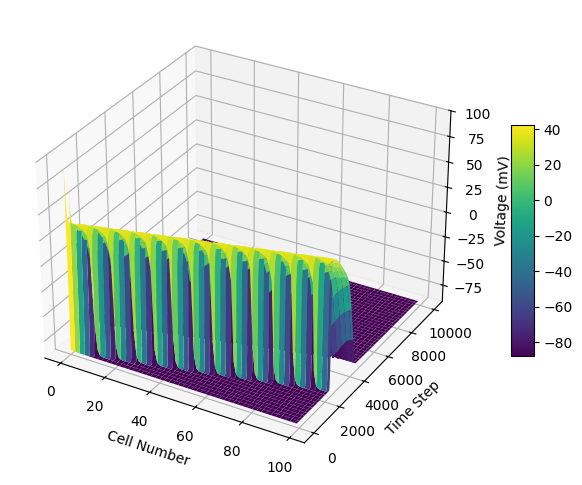

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# phi_save: shape (T_steps, N_cells)
data = phi_save.cpu().numpy()

T_steps, N_cells = data.shape

X = np.arange(T_steps)[:, None]           # time step axis
Y = np.arange(N_cells)[None, :]           # cell axis

X_grid, Y_grid = np.meshgrid(np.arange(N_cells),
                             np.arange(T_steps))

Z = data   # voltage


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X_grid, Y_grid, Z,
                       cmap='viridis', linewidth=0, antialiased=True)

ax.set_xlabel("Cell Number")
ax.set_ylabel("Time Step")
ax.set_zlabel("Voltage (mV)")

fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


## Test NN with simple GJ code

In [28]:
from Ionic_current.Ord11 import Ord11_model
from PermanentConstants import Constants,Normalization
import torch
import math
import time
from model import MLP
import joblib
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cpu')
dtype = torch.float32
GJ_coupling = 'strong'
full_seq = True

if full_seq:
    best_model_state_name = f"Model_state/MLP/best_mlp_{GJ_coupling}_fullseq.pth"
else:
    best_model_state_name = f"Model_state/MLP/best_mlp_{GJ_coupling}_fullseq.pth"

if GJ_coupling == 'strong':
    GJ = 735  # nS
    scaler_name = 'Scaler/MLP/strong_standard_scaler.pkl'
else:
    GJ = 73.5 # nS
    scaler_name = 'Scaler/MLP/weak_standard_scaler.pkl'

# Load the scaler
scaler = joblib.load(scaler_name)

normalize = Normalization(scaler, device=device, dtype=dtype)
mesh_parameters = torch.tensor(
    [100.0, 0.1, 0.1, 0.0, 32, 735.0],
    device=device,
    dtype=dtype
)  # d, dip, dp, Af, hip, Ggap
hidden_dims = [128, 128, 256, 256, 128]
const = Constants(
            device=device,
            dtype=dtype,
            Ncell=50,
            nbeats=2,
            dt_factor=10,
            stim_amplitude=50
            )
parameters = const.parameters
input_features = 9
output_features = 2
model = MLP(input_features, hidden_dims, output_features,dropout=0.1)
best_state = torch.load(best_model_state_name)
model.load_state_dict(best_state)
model.to(device)
model.eval()

T = np.linspace(0, const.T, phi_save.shape[0]) # type: ignore
phi_test = phi_save[:,49:52]  # pyright: ignore[reportArgumentType, reportCallIssue] # (N, 3)
mesh_parameters = mesh_parameters.unsqueeze(0).repeat(phi_save.shape[0], 1)  # type: ignore # (N, 6)
input = torch.cat([phi_test, mesh_parameters], dim=1)  # (N, 9)
normalize_input = normalize.normalizeV(input)
with torch.no_grad():
    I_cleft_pred = model(normalize_input)  # (N, 2)
    I_cleft_pred = normalize.denormalizeI(I_cleft_pred)
    I_cleft_pred = I_cleft_pred[:,0] + I_cleft_pred[:,1]  # (N,)
I_cleft_true = I_gap_save[:,50]  # pyright: ignore[reportCallIssue, reportArgumentType] # (N, 3)

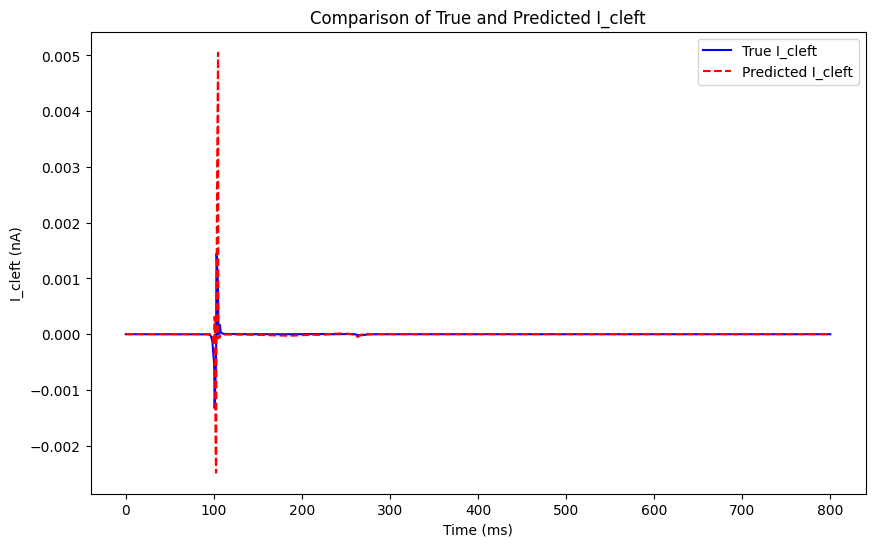

In [29]:
plt.figure(figsize=(10,6))
plt.plot(T, I_cleft_true.cpu().numpy(), label='True I_cleft', color='blue')
plt.plot(T, I_cleft_pred.cpu().numpy(), label='Predicted I_cleft', color='red', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('I_cleft (nA)')
plt.title('Comparison of True and Predicted I_cleft')
plt.legend()

### Simple GJ with only one NN

In [30]:
from Ionic_current.Ord11 import Ord11_model
from PermanentConstants import Constants,Normalization
import torch
import math
import time
from model import MLP
import joblib
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cpu')
dtype = torch.float32
GJ_coupling = 'strong'
full_seq = True

if full_seq:
    best_model_state_name = f"Model_state/MLP/best_mlp_{GJ_coupling}_fullseq.pth"
else:
    best_model_state_name = f"Model_state/MLP/best_mlp_{GJ_coupling}_fullseq.pth"

if GJ_coupling == 'strong':
    GJ = 735  # nS
    scaler_name = 'Scaler/MLP/strong_standard_scaler.pkl'
else:
    GJ = 73.5 # nS
    scaler_name = 'Scaler/MLP/weak_standard_scaler.pkl'

# Load the scaler
scaler = joblib.load(scaler_name)

normalize = Normalization(scaler, device=device, dtype=dtype)
mesh_parameters = torch.tensor(
    [100.0, 0.1, 0.1, 0.0, 32, 735.0],
    device=device,
    dtype=dtype
)  # d, dip, dp, Af, hip, Ggap
hidden_dims = [128, 128, 256, 256, 128]
const = Constants(
            device=device,
            dtype=dtype,
            Ncell=50,
            nbeats=1,
            dt_factor=10,
            bcl=1000,
            stim_amplitude=50,
            GJ_coupling=7.35e-5/4
            )
parameters = const.parameters
input_features = 9
output_features = 2
model = MLP(input_features, hidden_dims, output_features,dropout=0.1)
best_state = torch.load(best_model_state_name)
model.load_state_dict(best_state)
model.to(device)
model.eval()

D = 0.1 # mm^2/msec
dx = 0.1 #mm    
Ctot = parameters['Ctot']
# Ggap = Ctot * D / dx**2
Ggap = parameters['Ggap']  # nS 
Ncell = parameters['Ncell']
ti = 0.0
count = 0
dt = 0.01
phi_i = const.phi0.clone()
G_i   = const.g0.clone()
S     = const.S.clone()
state = torch.cat((phi_i, G_i), dim=0)
N = parameters['N']
phi_save  = []
I_gap_save = []
start = time.time()
T = []
with torch.no_grad():
    while ti < const.T:
    
        if count % 2000 == 0:
            print(f'time: {ti:.2f} ms')
        parameters['dt'] = dt

        Iion, _, G_new, dX =  Ord11_model(ti, state, parameters, S, device, dtype)

        if torch.isnan(Iion).any():
            print('NaN already in Iion! time:', ti)
            break
        I_gap    = torch.zeros(N, device=device, dtype=dtype)
        I_gap[1:-1] = Ggap * (phi_i[1:-1]-phi_i[:-2] + phi_i[1:-1]-phi_i[2:])
        I_gap[0] = Ggap * (phi_i[0] - phi_i[1])
        I_gap[-1] = Ggap * (phi_i[-1]-phi_i[-2])
        normalize_v = normalize.normalizeV(torch.cat([phi_i[23:26].unsqueeze(0), mesh_parameters.unsqueeze(0)], dim=1))
        I_model = model(normalize_v)
        I_model = normalize.denormalizeI(I_model)
        I_gap[24] = I_model.sum(axis=1)
        
        dphi = -(Iion + I_gap) / Ctot
        phi_new = phi_i + dt * dphi
        phi_i = phi_new

        state[0:N] = phi_new
        state[N:]  = G_new

        if count % 10 == 0:
            phi_save.append(phi_new.clone())
            I_gap_save.append(I_gap.clone())
            T.append(ti)
        
        if count % 100 == 0:
            if any(torch.isnan(phi_new)):
                print('NaN detected in membrane potential!, time:', ti)
                break
        # ti = round(ti + dt, 5) 
        ti += dt
        count += 1
end = time.time()
phi_save = torch.stack(phi_save, dim=0)
I_gap_save = torch.stack(I_gap_save, dim=0)

print(f'Simulation time: {end - start:.2f} seconds')

time: 0.00 ms
time: 20.00 ms
time: 40.00 ms
time: 60.00 ms
time: 80.00 ms
time: 100.00 ms
time: 120.00 ms
time: 140.00 ms
time: 160.00 ms
time: 180.00 ms
time: 200.00 ms
time: 220.00 ms
time: 240.00 ms
time: 260.00 ms
time: 280.00 ms
time: 300.00 ms
time: 320.00 ms
time: 340.00 ms
time: 360.00 ms
time: 380.00 ms
time: 400.00 ms
time: 420.00 ms
time: 440.00 ms
time: 460.00 ms
time: 480.00 ms
time: 500.00 ms
time: 520.00 ms
time: 540.00 ms
time: 560.00 ms
time: 580.00 ms
time: 600.00 ms
time: 620.00 ms
time: 640.00 ms
time: 660.00 ms
time: 680.00 ms
time: 700.00 ms
time: 720.00 ms
time: 740.00 ms
time: 760.00 ms
time: 780.00 ms
time: 800.00 ms
time: 820.00 ms
time: 840.00 ms
time: 860.00 ms
time: 880.00 ms
time: 900.00 ms
time: 920.00 ms
time: 940.00 ms
time: 960.00 ms
time: 980.00 ms
time: 1000.00 ms
Simulation time: 207.26 seconds


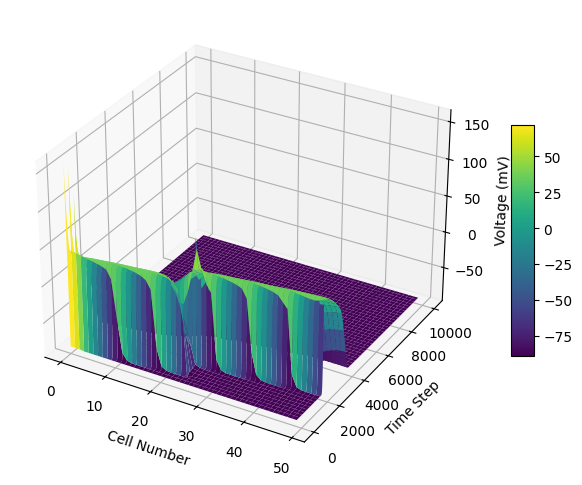

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# phi_save: shape (T_steps, N_cells)
data = phi_save.cpu().numpy()

T_steps, N_cells = data.shape

X = np.arange(T_steps)[:, None]           # time step axis
Y = np.arange(N_cells)[None, :]           # cell axis

X_grid, Y_grid = np.meshgrid(np.arange(N_cells),
                             np.arange(T_steps))

Z = data   # voltage


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X_grid, Y_grid, Z,
                       cmap='viridis', linewidth=0, antialiased=True)

ax.set_xlabel("Cell Number")
ax.set_ylabel("Time Step")
ax.set_zlabel("Voltage (mV)")

fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


## Plot I gap

### Simple GJ with multiple NN

time: 0.00 ms
time: 20.00 ms
time: 40.00 ms
time: 60.00 ms
time: 80.00 ms
time: 100.00 ms
time: 120.00 ms
time: 140.00 ms
time: 160.00 ms
time: 180.00 ms
time: 200.00 ms
time: 220.00 ms
time: 240.00 ms
time: 260.00 ms
time: 280.00 ms
time: 300.00 ms
time: 320.00 ms
time: 340.00 ms
time: 360.00 ms
time: 380.00 ms
time: 400.00 ms
time: 420.00 ms
time: 440.00 ms
time: 460.00 ms
time: 480.00 ms
time: 500.00 ms
time: 520.00 ms
time: 540.00 ms
time: 560.00 ms
time: 580.00 ms
time: 600.00 ms
time: 620.00 ms
time: 640.00 ms
time: 660.00 ms
time: 680.00 ms
time: 700.00 ms
time: 720.00 ms
time: 740.00 ms
time: 760.00 ms
time: 780.00 ms
time: 800.00 ms
time: 820.00 ms
time: 840.00 ms
time: 860.00 ms
time: 880.00 ms
time: 900.00 ms
time: 920.00 ms
time: 940.00 ms
time: 960.00 ms
time: 980.00 ms
time: 1000.00 ms
Simulation time: 256.04 seconds


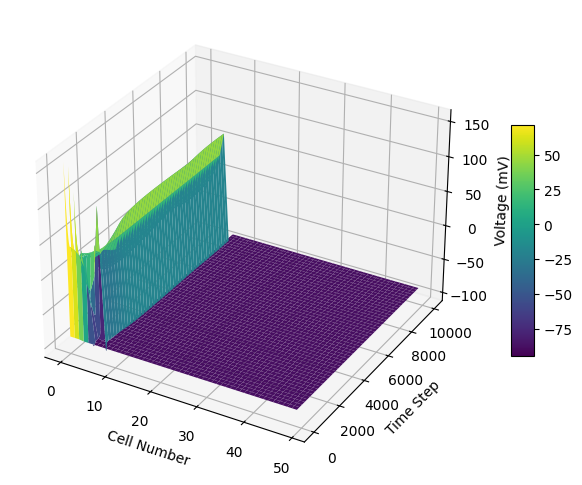

In [32]:
from Ionic_current.Ord11 import Ord11_model
from PermanentConstants import Constants,Normalization
import torch
import math
import time
from model import MLP
import joblib
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cpu')
dtype = torch.float32
GJ_coupling = 'strong'
full_seq = True

if full_seq:
    best_model_state_name = f"Model_state/MLP/best_mlp_{GJ_coupling}_fullseq.pth"
else:
    best_model_state_name = f"Model_state/MLP/best_mlp_{GJ_coupling}_fullseq.pth"

if GJ_coupling == 'strong':
    GJ = 735  # nS
    scaler_name = 'Scaler/MLP/strong_standard_scaler.pkl'
else:
    GJ = 73.5 # nS
    scaler_name = 'Scaler/MLP/weak_standard_scaler.pkl'

# Load the scaler
scaler = joblib.load(scaler_name)

normalize = Normalization(scaler, device=device, dtype=dtype)
mesh_parameters = torch.tensor(
    [100.0, 0.1, 0.1, 0.0, 32, 735.0],
    device=device,
    dtype=dtype
)  # d, dip, dp, Af, hip, Ggap
hidden_dims = [128, 128, 256, 256, 128]
const = Constants(
            device=device,
            dtype=dtype,
            Ncell=50,
            nbeats=1,
            dt_factor=10,
            bcl=1000,
            stim_amplitude=50,
            GJ_coupling=7.35e-5/4
            )
parameters = const.parameters
input_features = 9
output_features = 2
model = MLP(input_features, hidden_dims, output_features,dropout=0.1)
best_state = torch.load(best_model_state_name)
model.load_state_dict(best_state)
model.to(device)
model.eval()

Ggap = parameters['Ggap']  # nS     
D = 0.1 # mm^2/msec
dx = 0.1 #mm    
Ctot = parameters['Ctot']
# Ggap = Ctot * D / dx**2
Ncell = parameters['Ncell']
ti = 0.0
count = 0
dt = 0.01
phi_i = const.phi0.clone()
G_i   = const.g0.clone()
S     = const.S.clone()
state = torch.cat((phi_i, G_i), dim=0)
N = parameters['N']
phi_save  = []
I_gap_save = []
start = time.time()
T = []
with torch.no_grad():
    while ti < const.T:
    
        if count % 2000 == 0:
            print(f'time: {ti:.2f} ms')
        parameters['dt'] = dt

        Iion, _, G_new, dX =  Ord11_model(ti, state, parameters, S, device, dtype)

        if torch.isnan(Iion).any():
            print('NaN already in Iion! time:', ti)
            break
        I_gap    = torch.zeros(N, device=device, dtype=dtype)
        I_gap[1:-1] = Ggap * (phi_i[1:-1]-phi_i[:-2] + phi_i[1:-1]-phi_i[2:])
        I_gap[0] = Ggap * (phi_i[0] - phi_i[1])
        I_gap[-1] = Ggap * (phi_i[-1]-phi_i[-2])

        phi_NN = phi_i[4:-4].unfold(dimension=0, size=3, step=1)
        normalize_v = normalize.normalizeV(torch.cat([phi_NN, mesh_parameters.unsqueeze(0).repeat(phi_NN.shape[0], 1)], dim=1))
        I_model = model(normalize_v)
        I_model = normalize.denormalizeI(I_model)
        I_gap[5:-5] = I_model.sum(axis=1)
        
        dphi = -(Iion + I_gap) / Ctot
        phi_new = phi_i + dt * dphi
        phi_i = phi_new

        state[0:N] = phi_new
        state[N:]  = G_new

        if count % 10 == 0:
            phi_save.append(phi_new.clone())
            I_gap_save.append(I_gap.clone())
            T.append(ti)
        
        if count % 100 == 0:
            if any(torch.isnan(phi_new)):
                print('NaN detected in membrane potential!, time:', ti)
                break
        # ti = round(ti + dt, 5) 
        ti += dt
        count += 1
end = time.time()
phi_save = torch.stack(phi_save, dim=0)
I_gap_save = torch.stack(I_gap_save, dim=0)

print(f'Simulation time: {end - start:.2f} seconds')

import numpy as np
import matplotlib.pyplot as plt

# phi_save: shape (T_steps, N_cells)
data = phi_save.cpu().numpy()

T_steps, N_cells = data.shape

X = np.arange(T_steps)[:, None]           # time step axis
Y = np.arange(N_cells)[None, :]           # cell axis

X_grid, Y_grid = np.meshgrid(np.arange(N_cells),
                             np.arange(T_steps))

Z = data   # voltage


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X_grid, Y_grid, Z,
                       cmap='viridis', linewidth=0, antialiased=True)

ax.set_xlabel("Cell Number")
ax.set_ylabel("Time Step")
ax.set_zlabel("Voltage (mV)")

fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()
